# Introduction

this project involving the classification of dogs and cats using a Support Vector Machine (SVM) classifier.

# Import Libraries

In [15]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc,f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image, UnidentifiedImageError


# Load and Explore Dataset


                                           file_path label
0  /kaggle/input/cats-vs-dogs-1000/dogs_cats_samp...  cats
1  /kaggle/input/cats-vs-dogs-1000/dogs_cats_samp...  cats
2  /kaggle/input/cats-vs-dogs-1000/dogs_cats_samp...  cats
3  /kaggle/input/cats-vs-dogs-1000/dogs_cats_samp...  cats
4  /kaggle/input/cats-vs-dogs-1000/dogs_cats_samp...  cats


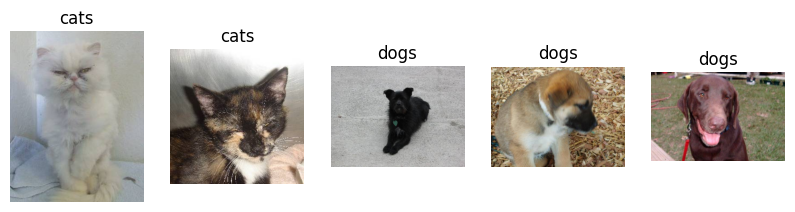

In [16]:
data_path = '/kaggle/input/cats-vs-dogs-1000/dogs_cats_sample_1000/train' 
img_size = 64 
categories=['cats','dogs']
file_paths=[]
labels=[]

# we will loop through each category and collect file paths and labels
for category in categories :
    category_path = os.path.join(data_path,category)
    for img_name in os.listdir(category_path):
        img_path=os.path.join(category_path,img_name)
        if os.path.isfile(img_path):
            file_paths.append(img_path)
            labels.append(category)
#now we create a DataFrame to hold the file paths and labels
data=pd.DataFrame({
    'file_path':file_paths,
    'label': labels
})
# Display the first few rows of the DataFrame 
print(data.head())
# Function to display a few sample images
def display_few (data,num_samples=5):
    samples=data.sample(num_samples)
    plt.figure(figsize=(10,10))
    for i,(file_path , label) in enumerate (zip(samples['file_path'],samples['label'])):
        img=Image.open(file_path)
        plt.subplot(1,num_samples,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()
display_few(data)

# Data Preprocessing

In [17]:
from sklearn.preprocessing import LabelEncoder
from PIL import Image, UnidentifiedImageError

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Now we create a function to preprocess the images
def prepro_img(img_path, target_size=(64, 64)):
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize pixel values
        if img_array.shape == (64, 64, 3):  # Ensure the image has the correct shape
            return img_array
        else:
            return None
    except (UnidentifiedImageError, OSError):
        return None

# Apply preprocessing to all images
data['image'] = data['file_path'].apply(prepro_img)

# Remove rows with None values (non-image files or incorrect shapes)
data = data.dropna(subset=['image'])

# Split data into features and labels
x = np.stack(data['image'].values)
y = data['label'].values
X_flattened = x.reshape(x.shape[0], -1)
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_flattened)



# Split Data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Optimize SVM with GridSearchCV

In [ ]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly']
}
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits


# Evaluate Model

In [ ]:
# Evaluate the optimized model
svm_optimized = grid_search.best_estimator_
y_pred = svm_optimized.predict(X_test)

# Accuracy and Classification Report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot ROC Curve
y_score = svm_optimized.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Conclusion

Support Vector Machines (SVMs) are not ideal for image classification due to several inherent limitations:

Feature Dimensionality:

A 64x64 RGB image has 12,288 features.
A 224x224 RGB image has 150,528 features.
These high dimensions make SVMs computationally expensive and less effective.

Image Understanding:

SVMs treat each pixel as an independent feature and do not understand spatial relationships in images.
SVMs work with "flat" features and don't naturally capture the spatial relationships in images They don't understand that nearby pixels are related, unlike CNNs which have this built into their architecture

Better Alternatives:

Convolutional Neural Networks (CNNs): Best suited for image classification as they are designed to handle the spatial nature of image data.

Transfer Learning: Using pre-trained models like ResNet, VGG, or MobileNet can significantly improve performance.

Decision Trees/Random Forests: When combined with feature extractors like Histogram of Oriented Gradients (HOG), they can be more effective than SVMs.